# PYNQ SOBEL


	
 Engineer:  :  Clancy lee
 
 NAME     : PYNQ Z1
 
 Data     : sep, 2018
 
 School    : jiang nan university
 
 Design Name: sobel --pynq z1
 
 Description : Sobel Filter HLS Synthesis Code
 


In [10]:
#==================================================
#                Load overlay
#=================================================
from pynq import Overlay
overlay = Overlay("/home/xilinx/jupyter_notebooks/sobel/sobel.bit")
overlay?

In [2]:
#==================================================
#                Load sobel IP
#=================================================
sobel_ip=overlay.sobel_filter_0
sobel_ip?
sobel_ip.mmio
overlay.ip_dict

{'sobel_filter_0': {'addr_range': 4096,
  'driver': pynq.overlay.DefaultIP,
  'fullpath': 'sobel_filter_0',
  'gpio': {},
  'interrupts': {},
  'phys_addr': 1136656384,
  'state': None,
  'type': 'xilinx.com:hls:sobel_filter:1.0'}}

In [3]:
#===============================================
#                  load the image
#==============================================
from PIL import Image as PIL_Image
import numpy as np


orig_img_path = "/home/xilinx/jupyter_notebooks/sobel/test_1080p.bmp"
try:
    img = PIL_Image.open(orig_img_path)
    print("Open pictrue success!")
except IOError:
    print('fail to load image!')
   
#显示图片及图片信息
print("pictrue format:",img.format)
print("pictrue size:",img.size) #注意，省略了通道 (w，h)
print("pictrue mode:",img.mode)  #L为灰度图，RGB为真彩色,RGBA为加了透明通道

#RGB 通道分离
img_r,img_g,img_b = img.split()
#img = PIL_Image.merge("RGB",(r,g,b))

#R,G,B转矩阵
image_array_r = np.array(img_r,dtype='uint8')
image_array_g = np.array(img_g,dtype='uint8')
image_array_b = np.array(img_b,dtype= 'uint8')

print("img_r array shape:",image_array_r.shape)
print("img_r array dtype:",image_array_r.dtype)

Open pictrue success!
pictrue format: BMP
pictrue size: (1920, 1080)
pictrue mode: RGB
img_r array shape: (1080, 1920)
img_r array dtype: uint8


In [4]:
#===============================================
#            allocated  memory
#==============================================
from pynq import Xlnk
import numpy as np
   

nrows = 1080
ncols = 1920
xlnk = Xlnk()
#allocated the memory  inbuff
RGB_IN = xlnk.cma_array(shape=(nrows*ncols,), dtype=np.uint32)
in_buffer_address=RGB_IN.physical_address

#allocated the memory  outbuff
RGB_OUT = xlnk.cma_array(shape=(nrows*ncols,), dtype=np.uint32)
out_buffer_address=RGB_OUT.physical_address





In [5]:

#===============================================
#           write image to memroy
#==============================================

#write the image to RGB
RGB_3D = image_array_r*65536+image_array_g*256+image_array_b
np.copyto(RGB_IN,RGB_3D.flatten())
print(RGB_IN)

from pynq import MMIO
mmio = MMIO(in_buffer_address,nrows*ncols)
#mmio.read(in_buffer_address,nrows*ncols)



[1448737 1185565 1448737 ... 1775898 3025967 1447448]


In [6]:
#===============================================
#                  sobel hw Ex
#==============================================
from pynq import MMIO
       
#define XSOBEL_FILTER_AXI4_LITE_SLAVE_ADDR_AP_CTRL            0x00
#define XSOBEL_FILTER_AXI4_LITE_SLAVE_ADDR_GIE                0x04
#define XSOBEL_FILTER_AXI4_LITE_SLAVE_ADDR_IER                0x08
#define XSOBEL_FILTER_AXI4_LITE_SLAVE_ADDR_ISR                0x0c
#define XSOBEL_FILTER_AXI4_LITE_SLAVE_ADDR_BYTE_RDOFFSET_DATA 0x14
#define XSOBEL_FILTER_AXI4_LITE_SLAVE_ADDR_BYTE_WROFFSET_DATA 0x1c
#define XSOBEL_FILTER_AXI4_LITE_SLAVE_ADDR_ROWS_DATA          0x24
#define XSOBEL_FILTER_AXI4_LITE_SLAVE_ADDR_COLS_DATA          0x2c
#define XSOBEL_AXI4_LITE_SLAVE_ADDR_BYTE_FRAMEIN_OFFSET_DATA  0x34

#write data
byte_framein_offset = 1920
nrows               = 1080
ncol                = 1920


#address
IP_BASE_ADDRESS    =  0x43C00000
ADDRESS_RANGE      =  1000
#address offset
ADDR_AP_CRTL       =  0x00
ADDR_GIE           =  0x04
ADDR_IER           =  0x08
ADDR_ISR           =  0x0c

ADDR_ROWS          =  0x24       
ADDR_COLS          =  0x2c
ADDR_RDOFFSET       = 0x14
ADDR_WROFFSET       = 0x1c
ADDR_FRAMEIN_OFFSET = 0x34

# sobel mapping memory
def XSOBEL_Init_EX():
    # mapping memory

    mmio = MMIO(IP_BASE_ADDRESS,ADDRESS_RANGE)
    mmio.write(ADDR_ROWS,nrows)
    mmio.write(ADDR_COLS,ncol)
    mmio.write(ADDR_RDOFFSET,in_buffer_address)
    mmio.write(ADDR_WROFFSET,out_buffer_address)
    mmio.write(ADDR_FRAMEIN_OFFSET,byte_framein_offset)
    
    print("inbuff_address:",mmio.read(ADDR_RDOFFSET))
    print("out_buffer_address:",mmio.read(ADDR_WROFFSET))
    print("nrows:",mmio.read(ADDR_ROWS))
    print("ncol:",mmio.read(ADDR_COLS))
    print("byte_framein_offse:",mmio.read(ADDR_FRAMEIN_OFFSET))
    
#Start Or Stop the FPGA IP Core   start = 1; stop = 0;       
def XSOBEL_StartStop_Ex(state):
    # mapping memory
    mmio = MMIO(IP_BASE_ADDRESS,ADDRESS_RANGE )
    if(state):
        #enable the interrupt
        #enable the interrupt global
        mmio.write(ADDR_GIE,1)
        mmio.write(ADDR_IER,1)
        
        #Start the filter
        mmio.write(ADDR_AP_CRTL,0x1)
    else:
        while True:
            ap_done =  (mmio.read(ADDR_AP_CRTL)>>1)&0x01
            if(ap_done):
                break
                
        mmio.write(ADDR_GIE,0x0)
        mmio.write(ADDR_IER,0x0)

In [7]:
#===============================================
#                  sobel hw Ex  
#==============================================
import numpy
import time
#Set Control Registers State Or Value
XSOBEL_Init_EX() 
time.sleep(3)

#Start The FPGA IP Core
start = time.time()
XSOBEL_StartStop_Ex(1)
#Stop The FPGA IP Core check Whether The IP Core is End
XSOBEL_StartStop_Ex(0)
stop = time.time()
time_sobel_fpga = stop - start
print("Sobel FPGA time:",time_sobel_fpga)
time.sleep(3)

inbuff_address: 378535936
out_buffer_address: 386924544
nrows: 1080
ncol: 1920
byte_framein_offse: 1920
Sobel FPGA time: 0.06599640846252441


Sobel software time: 2.4582083225250244


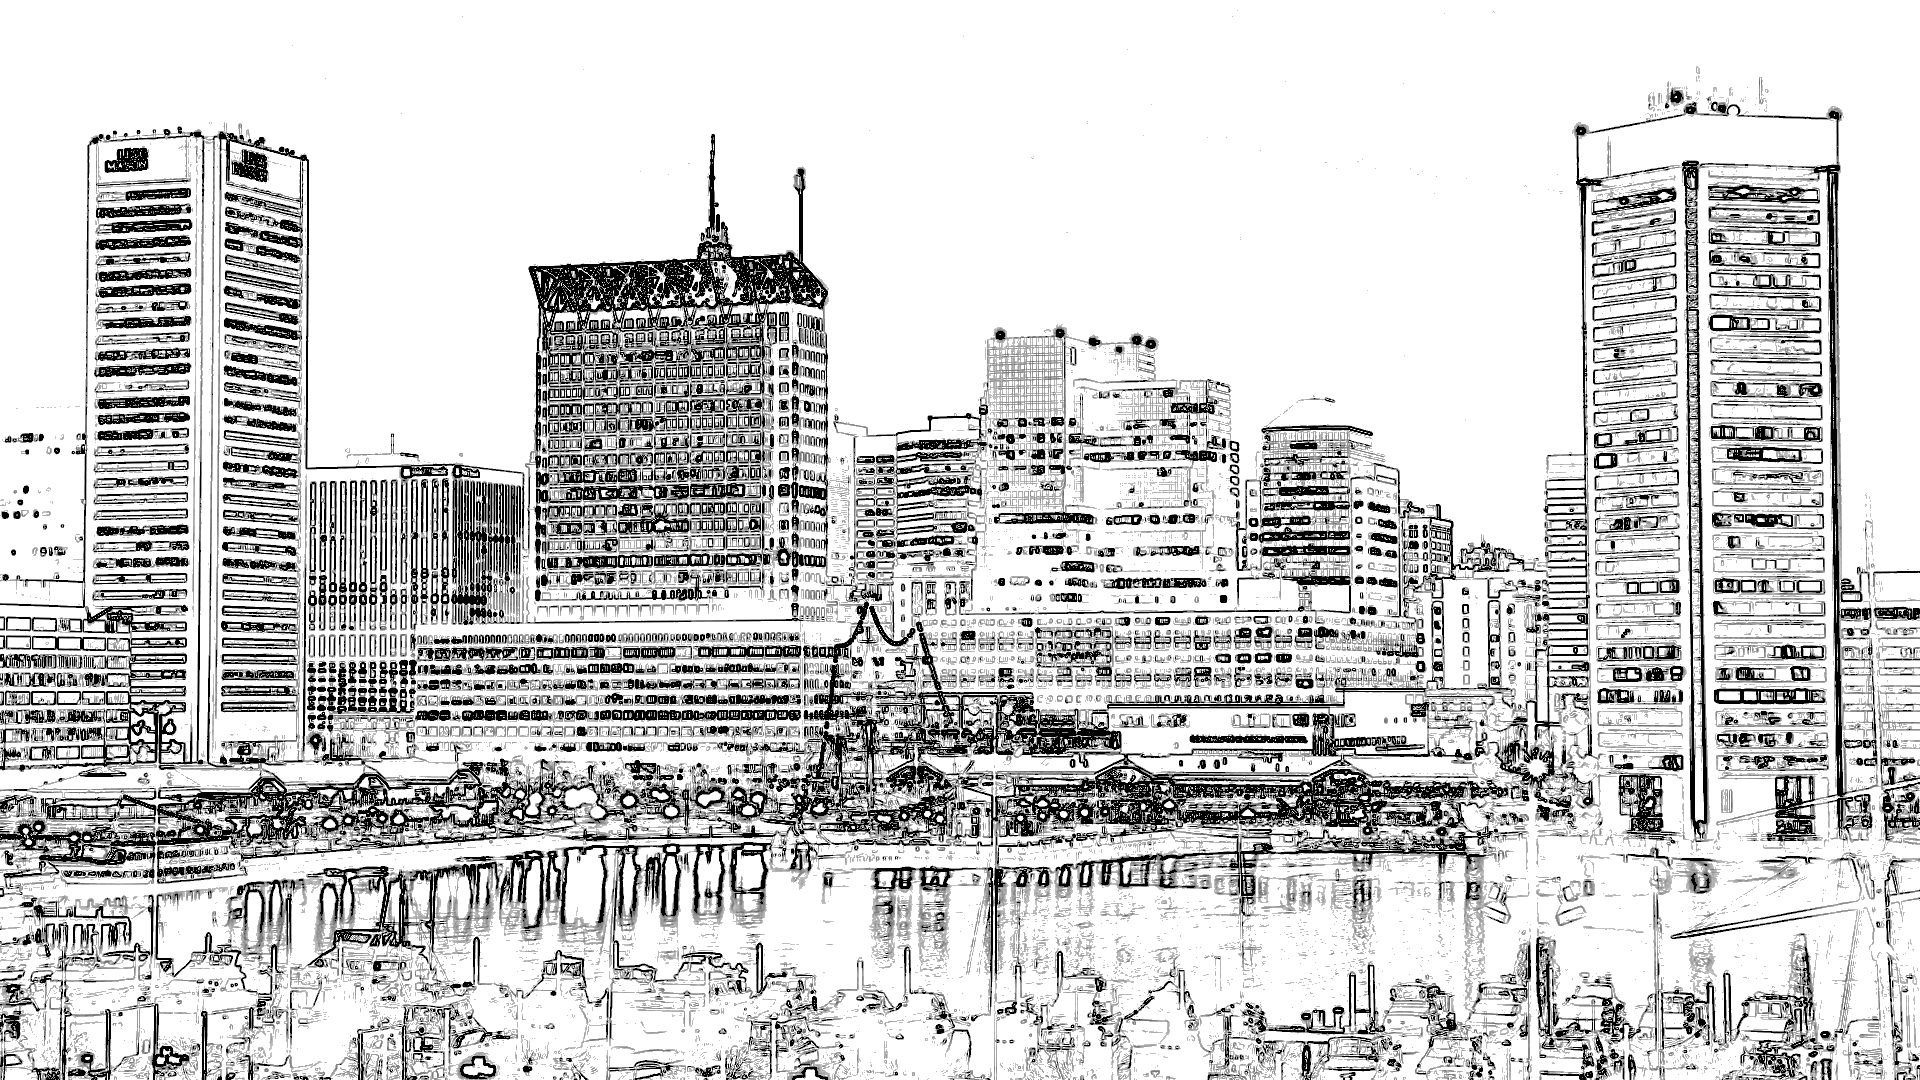

In [8]:
#===============================================
#                  sobel software run
#==============================================

from scipy.ndimage import filters
from numpy import *

start1 = time.time()
img_soft = np.array(PIL_Image.open(orig_img_path).convert('L'))

imx = np.zeros(img_soft.shape)
filters.sobel(img_soft,1,imx)

imy = np.zeros(img_soft.shape)
filters.sobel(img_soft,0,imy)
magnitude = 255-sqrt(imx**2+imy**2)

magnitude[magnitude> 200] =255
magnitude[magnitude< 100] =0

img_sobel = PIL_Image.fromarray(magnitude.astype('uint32')).convert('RGB')

stop1 = time.time()
time_sobel_soft = stop1 - start1

print("Sobel software time:",time_sobel_soft)

img_sobel

The image via sobel filter!!  <PIL.Image.Image image mode=RGB size=1920x1080 at 0x2B1F6E30>


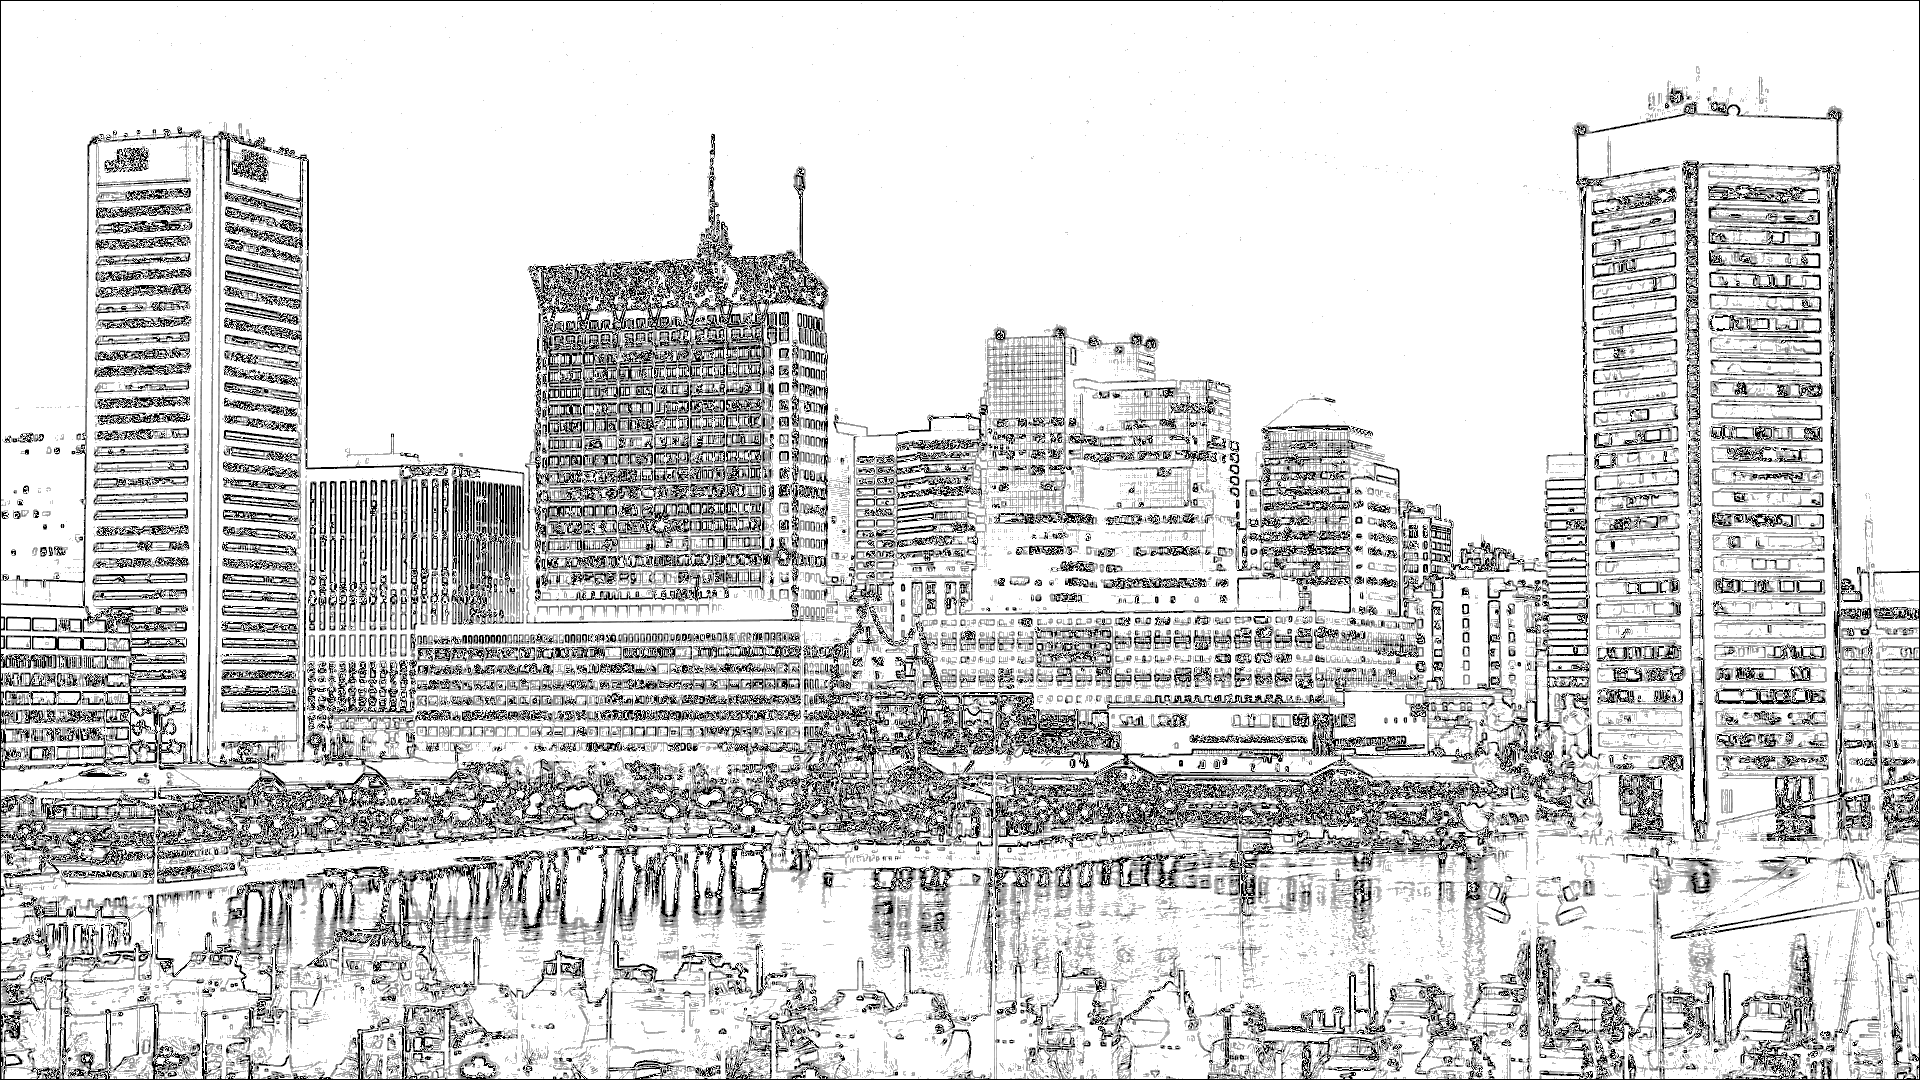

In [9]:

#===============================================
#           read image from memroy 
#==============================================

RGB_temp = np.zeros(1080*1920,dtype = np.uint32)
RGB_temp = RGB_OUT.copy()
RGB_temp = numpy.array(RGB_temp).reshape(1080,1920)


image_array_r = RGB_temp//65536
image_array_g = RGB_temp//256
image_array_b = RGB_temp


#img = PIL_Image.merge("RGB",(r,g,b))
image_r = PIL_Image.fromarray(image_array_r.astype('uint8')).convert('RGB')
image_g = PIL_Image.fromarray(image_array_g.astype('uint8')).convert('RGB')
image_b = PIL_Image.fromarray(image_array_b.astype('uint8')).convert('RGB')

print("The image via sobel filter!! ",image_b)
image_r